# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [16]:
PATH = "./data/"

In [17]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [18]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [19]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [21]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [26]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [27]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9635536838332475

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

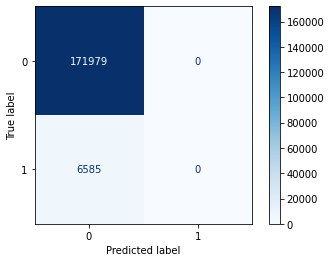

In [17]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [22]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

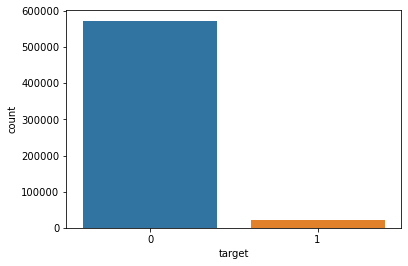

In [23]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [30]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

In [20]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [28]:
print('gini:    ', gini_normalized(y_valid, y_pred))
print('2*AUC-1: ',2*roc_auc_score(y_valid, y_pred)-1)

gini:     0.2558723581569817
2*AUC-1:  0.25587235816871434


<img src="./data/gini.auc.png" style="width:500px">

The Gini Coefficient is a direct conversion from AUC through a simple formula: Gini = (AUC x 2) -1. They measure exactly the same. And it is possible to go directly from one measure to the other, back and forth. The only reason to use Gini over AUC is the improvement in the scale’s interpretability: while the scale of a good predicting model AUC goes from 0.5 to 1, the scale in the case of Gini goes from 0 to 1.

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

There are other ranking metrics that are less widely used, such as modification to the ROC Curve for imbalanced classification. And like the ROC AUC, we can calculate the area under the curve as a score and use that score to compare classifiers. In this case, the focus on the minority class makes the **PR AUC**(Precision-Recall AUC) more useful for imbalanced classification problems.

Let's calculate the Normalized Gini Coefficient:

In [25]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [26]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

Since our data is highly imbalanced, we will perform a stratified split on our dataset. It will preserve the percentage of samples for our split. The predictions of an unstratified split will not preserve the original distribution of our target class. Therefore an imbalanced dataset should be split in a stratified manner

In [14]:
#percentage of missing values
(insurance_data == -1).mean().round(4)*100

target             0.00
ps_ind_01          0.00
ps_ind_02_cat      0.04
ps_ind_03          0.00
ps_ind_04_cat      0.01
ps_ind_05_cat      0.98
ps_ind_06_bin      0.00
ps_ind_07_bin      0.00
ps_ind_08_bin      0.00
ps_ind_09_bin      0.00
ps_ind_10_bin      0.00
ps_ind_11_bin      0.00
ps_ind_12_bin      0.00
ps_ind_13_bin      0.00
ps_ind_14          0.00
ps_ind_15          0.00
ps_ind_16_bin      0.00
ps_ind_17_bin      0.00
ps_ind_18_bin      0.00
ps_reg_01          0.00
ps_reg_02          0.00
ps_reg_03         18.11
ps_car_01_cat      0.02
ps_car_02_cat      0.00
ps_car_03_cat     69.09
ps_car_04_cat      0.00
ps_car_05_cat     44.78
ps_car_06_cat      0.00
ps_car_07_cat      1.93
ps_car_08_cat      0.00
ps_car_09_cat      0.10
ps_car_10_cat      0.00
ps_car_11_cat      0.00
ps_car_11          0.00
ps_car_12          0.00
ps_car_13          0.00
ps_car_14          7.16
ps_car_15          0.00
ps_calc_01         0.00
ps_calc_02         0.00
ps_calc_03         0.00
ps_calc_04      

In [36]:
lr = SGDClassifier(loss='log', penalty = 'l1', n_jobs=-1)
lr.fit(X_train, y_train)

auc_lr = roc_auc_score(y_valid, lr.predict_proba(X_valid)[:,1])
gini_lr = gini_normalized(y_valid, lr.predict_proba(X_valid)[:,1])

In [37]:
print('Gini:', gini_lr)
print('AUC:', auc_lr)

Gini: 0.2211177442311096
AUC: 0.6105588721217652


In [118]:
data_test = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv')).set_index('id')

In [119]:
data_test_scaled = StandardScaler().fit_transform(data_test)

In [120]:
# test_id = data_test.index
pred_test = lr.predict_proba(data_test_scaled)[:,1]

In [121]:
submission = pd.DataFrame()
submission['id'] = np.arange(data_test.shape[0])
submission['target'] = pred_test
submission.to_csv('my_submission.csv', index = False)

In [122]:
sub = pd.read_csv('my_submission.csv').set_index('id')

<img src="./data/score.png">

calculate Y bonus points,
0.217*0.253 < 0 so I've deserved 0 additional points